In [10]:
"""
This Script Uses Ping's Instagram Private Api
https://github.com/ping/instagram_private_api.git

"""

"""Clone the Repo and add this jupyter file into the repo"""
import pandas as pd
import time
import csv
import time

from pandas import json_normalize

from instagram_private_api import Client

import matplotlib.pyplot as plt

In [11]:

login_username = ''
login_password = ''
client_name = ''  # the name of the person who need the username
target_profile = 'beemscatering'  # the profile post your are scraping data from
no_of_post = 195

In [12]:
api = Client(login_username, login_password, timeout=30, cookie=False)

In [13]:
def get_posts(api, username, no_of_posts):
    """ Get no of posts  by username"""
    posts = []
    has_more_posts = True
    max_Id = ''

    while has_more_posts:
        userfeed = api.username_feed(username, max_id=max_Id)

        if userfeed['more_available'] is not True:
            has_more_posts = False
        max_Id = userfeed.get('next_max_id', '')
        posts.extend(userfeed['items'])
        time.sleep(2)

        if has_more_posts:
            print(str(len(posts)) + ' post retrieved so far.....')
            if len(posts) > no_of_posts:
                break
    print('Total posts retrieved: ' + str(len(posts)))

    return posts

In [14]:
def post_likers(api, posts):
    """ Get the likers from the posts"""
    likers = []

    print(f'wait {len(posts) * 2 / 60} minutes')
    for i in range(len(posts)):
        m_id = posts[i]['id']  # m_id is media id
        likes = api.media_likers(m_id)

        likers += [likes]

        likers[i]['post_id'] = m_id

        time.sleep(2)
    print('finished')

    return likers

In [15]:
def post_commenters(api, posts):
    """Gets the commenters from the post"""
    commenters = []
    print(f'wait {len(posts) * 2 / 60} minutes')
    for i in range(len(posts)):
        m_id = posts[i]['id']  # m_id is media id
        likes = api.media_comments(m_id)

        commenters += [likes]

        commenters[i]['post_id'] = m_id

        time.sleep(2)
    print('finished')

    return commenters

In [16]:
def convert_likes_to_df(likers):
    """ Converts the likers into a dataframe"""
    df_likers = json_normalize(likers, 'users', ['post_id'])

    return df_likers


def convert_commenters_to_df(commenters):
    """ Converts the commenters into a dataframe"""
    for i in range(len(commenters)):
        if len(commenters[i]['comments']) > 0:  # if there's comment
            for j in range(len(commenters[i]['comments'])):
                commenters[i]['comments'][j]['username'] = commenters[i]['comments'][j]['user']['username']
                commenters[i]['comments'][j]['full_name'] = commenters[i]['comments'][j]['user']['full_name']
    df_commenters = json_normalize(commenters, 'comments', 'post_id')

    return df_commenters


In [17]:
posts = get_posts(api, target_profile, no_of_post)

18 post retrieved so far.....
36 post retrieved so far.....
Total posts retrieved: 39


In [18]:
likers = post_likers(api, posts)

wait 1.3 minutes
finished


In [19]:
df_likers = convert_likes_to_df(likers)
likers_username = df_likers.username  # Number of top liker
clean_likes_only = likers_username.drop_duplicates()  # removes duplicates
print(f'cleaned like username: {len(clean_likes_only)}')
clean_likes_only.to_csv(f'{client_name}_likes.csv', index=False, header=False)
print(f'{client_name}_likes saved')

cleaned like username: 79
beemscatering_likes saved


In [20]:
commenters = post_commenters(api, posts)

wait 1.3 minutes
finished


In [21]:
df_commenters = convert_commenters_to_df(commenters)
commenters_username = df_commenters['username']
clean_comments_only = commenters_username.drop_duplicates()  # removes duplicates
print(f'clean comments username: {len(clean_comments_only)}')
clean_comments_only.to_csv(
    f'{client_name}_comments.csv', index=False, header=False)
print(f'{client_name}_comments saved')

clean comments username: 9
beemscatering_comments saved


In [22]:


comments_n_likes = set(clean_likes_only).intersection(clean_comments_only)
print(f'usernames that comment and like page: {len(comments_n_likes)}')

''' Save uersnames that Comment and like target page to file'''
with open(f'{client_name}_likes_comments.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter='\n')
    csvwriter.writerow(comments_n_likes)
print(f'{client_name}_likes_n_comments saved')

usernames that comment and like page: 8
beemscatering_likes_n_comments saved


In [23]:
"""
    saves top 100 likers to txt file
"""
top_likers = df_likers['username'].value_counts()[:100]
with open(f'{client_name} top 100 likers.txt','w') as f:
    top_likers.to_string(f)
"""
    saves top 100 commenters to txt file
"""
top_commenters = df_commenters['username'].value_counts()[:100]
with open(f'{client_name} top 100 commenters.txt','w') as f:
    top_commenters.to_string(f)

print(f"Top 100 likers : {top_likers}")

print(f"Top 100 commenters : {top_commenters}")




Top 100 likers : auntynurse005       39
melly_luxuries      39
bimbola.ade         39
minet07             38
wunmi_ashimi        38
                    ..
whereisliz           1
princess_daniel1     1
cynthiaakeredolu     1
hypersannipixels     1
muka1968             1
Name: username, Length: 79, dtype: int64
Top 100 commenters : fattysplace_       2
auntynurse005      1
bimbola.hayat      1
emmy_eco           1
officialdjsmart    1
oyeakinpade        1
maf.foods          1
sani3_39           1
black_jesuz2512    1
Name: username, dtype: int64


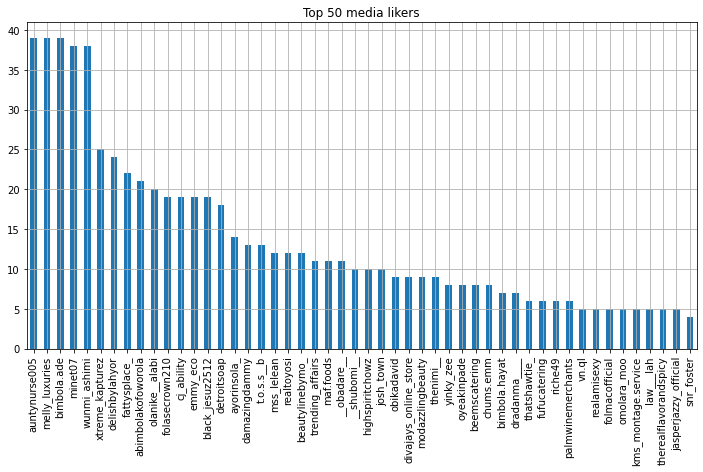

In [24]:
top_likers_fig = df_likers.username.value_counts()[:50].plot(kind='bar', title='Top 50 media likers', grid=True, figsize=(12,6))
comment_fig = top_likers_fig.get_figure()
comment_fig.savefig(f'{client_name} Top likers graph.pdf')

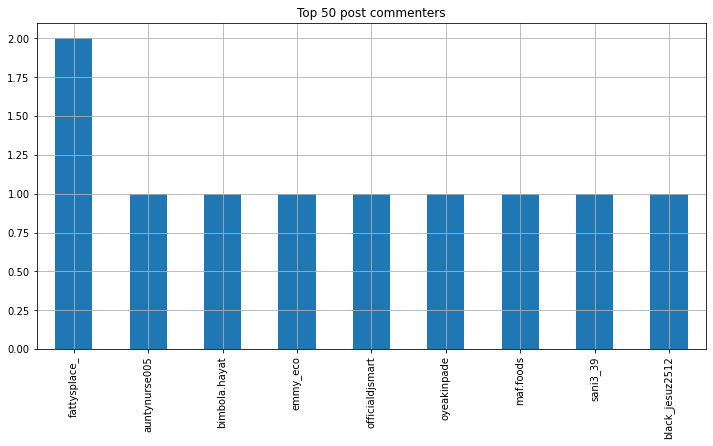

In [25]:
top_commenters_fig = df_commenters['username'].value_counts()[:50].plot(kind='bar', figsize=(12,6),grid=True, title='Top 50 post commenters')
comment_fig = top_commenters_fig.get_figure()
comment_fig.savefig(f'{client_name} Top Commenters graph.pdf')

In [26]:
df_commenters.created_at = pd.to_datetime(df_commenters.created_at, unit = 's')
df_commenters.created_at_utc = pd.to_datetime(df_commenters.created_at_utc, unit='s')

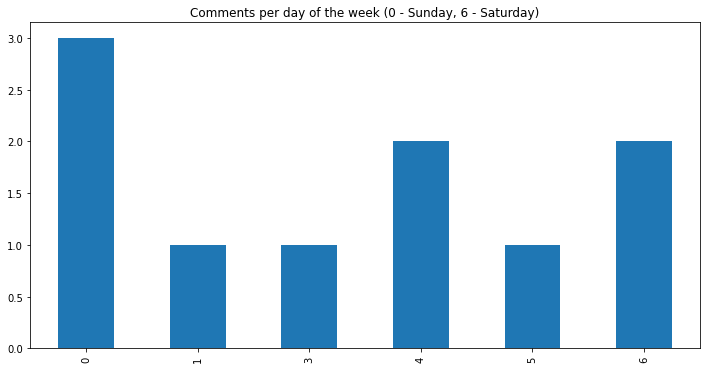

In [27]:
comment_per_day = df_commenters.created_at.dt.weekday.value_counts().sort_index().plot(kind='bar', figsize=(12,6), title='Comments per day of the week (0 - Sunday, 6 - Saturday)')
comment_per_day_fig = comment_per_day.get_figure()
comment_fig.savefig(f'{client_name} comments per day.pdf')